In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from toolz import sliding_window
from aging.util import correct_for_camera_height
from scipy.spatial.distance import pdist, squareform
from aging.plotting import figure, format_plots, save_factory, PlotConfig, add_identity

In [2]:
c = PlotConfig()
format_plots()
saver = save_factory(c.save_path / "syllable-scalars-across-age", tight_layout=False)

In [3]:
version = 7
path = Path(f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_syllable_df_v00.parquet")
df = pd.read_parquet(path, engine="pyarrow")

In [4]:
def age_map_fun(age):
    try:
        return int(age.split("w")[0])
    except ValueError:
        return {"3": 12, "6": 24, "9": 35, "12": 52, "18": 78, "22": 90}[
            age.split("m")[0]
        ]

In [5]:
unique_ages = df['age'].unique()

In [6]:
age_map = dict(zip(unique_ages, map(age_map_fun, unique_ages)))
df['age'] = df['age'].map(age_map).astype('int16[pyarrow]')

In [7]:
df["corrected_width"] = correct_for_camera_height(df["width_px"], df["true_depth"])
df["corrected_length"] = correct_for_camera_height(df["length_px"], df["true_depth"])
area = df["area_px"]
df["corrected_area"] = np.square(
    correct_for_camera_height(np.sqrt(area[area > 0]), df.loc[area > 0, "true_depth"])
)
df['corrected_velocity_2d'] = correct_for_camera_height(df['velocity_2d_px'], df['true_depth'])

In [8]:
df.columns

Index(['experiment', 'file', 'syllables', 'date', 'uuid', 'age', 'true_depth',
       'session_name', 'subject_name', 'timestamps', 'raw_timestamps',
       'area_mm', 'area_px', 'centroid_x_mm', 'centroid_x_px', 'centroid_y_mm',
       'centroid_y_px', 'height_ave_mm', 'length_mm', 'length_px',
       'velocity_2d_mm', 'velocity_2d_px', 'velocity_3d_mm', 'velocity_3d_px',
       'width_mm', 'width_px', 'angle', 'velocity_theta', 'recon_width',
       'recon_length', 'recon_height', 'recon_area', 'onsets',
       'corrected_width', 'corrected_length', 'corrected_area',
       'corrected_velocity_2d'],
      dtype='object')

In [50]:
pl_df = pl.DataFrame(
    df[
        [
            "age",
            "corrected_velocity_2d",
            "session_name",
            "uuid",
            "subject_name",
            "syllables",
            "onsets",
            "corrected_width",
            "corrected_length",
            "height_ave_mm",
            "recon_height",
        ]
    ]
)


In [51]:
pl_df = pl_df.lazy().with_columns(
    pl.col("onsets").cumsum().alias("syllable_instance"),
    (~pl.col("corrected_velocity_2d").is_null()).shift(1).fill_null(False)
    * pl.col("corrected_velocity_2d"),
).with_columns(
    pl.when(pl.col("corrected_velocity_2d") == 0)
    .then(None)
    .otherwise(pl.col("corrected_velocity_2d"))
    .name.keep()
).filter(pl.col("corrected_velocity_2d") < 10).collect()

In [52]:
instance_avgs = pl_df.group_by(
    ["syllable_instance", "session_name", "uuid", "subject_name", "age", "syllables"]
).mean()

In [ ]:
session_avgs = instance_avgs.group_by(
    ["session_name", "uuid", "subject_name", "age", "syllables"]
).mean()
session_avgs = session_avgs[[s.name for s in session_avgs if not (s.null_count() == session_avgs.height)]]

In [53]:
# groupby syllables and age, take mean
syllable_avgs = instance_avgs.group_by(["syllables", "age"]).mean().with_columns(pl.col("syllables").cast(pl.UInt16))
syllable_avgs = syllable_avgs[[s.name for s in syllable_avgs if not (s.null_count() == syllable_avgs.height)]]

# then create pivot table and plot heatmap

## Plot velocity for each syllable and age

In [102]:
syll_scalar_age_tbl = syllable_avgs.to_pandas().pivot_table(
    index="syllables", columns="age", values="corrected_velocity_2d", aggfunc="median"
) * 30
syll_scalar_age_tbl.index.rename("Syllable ID", inplace=True)
syll_scalar_age_tbl.columns.rename("Age (weeks)", inplace=True)
drop_mask = syll_scalar_age_tbl.isna().sum(axis=1) > 3
sorting = syll_scalar_age_tbl[~drop_mask].mean(axis=1).sort_values(ascending=False).index

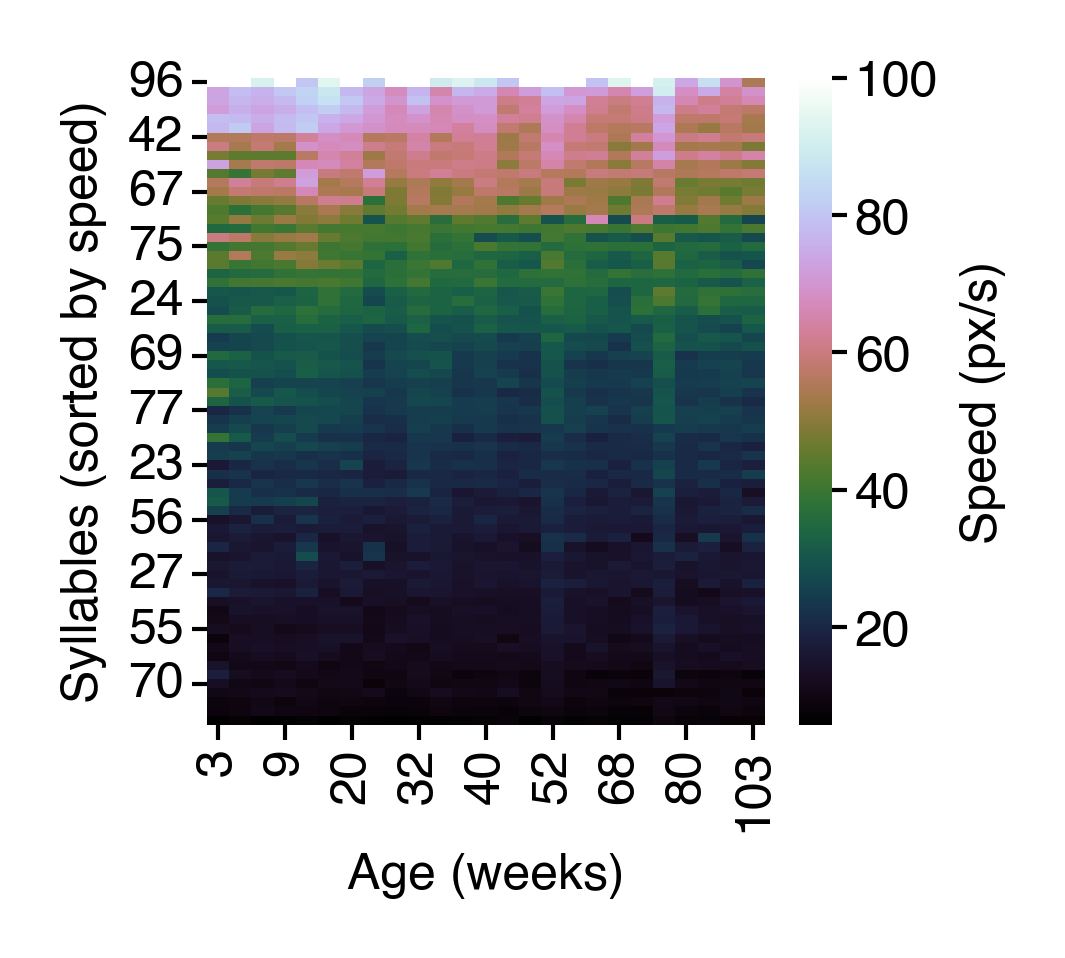

In [90]:
fig = figure(1.5, 1.4)
ax = sns.heatmap(
    syll_scalar_age_tbl.loc[sorting],
    cmap="cubehelix",
    cbar_kws={"label": "Speed (px/s)"},
    vmax=100,
)
ax.set(ylabel="Syllables (sorted by speed)")
saver(fig, "syllables-vs-speed-heatmap");

### Plot individual syllable across age

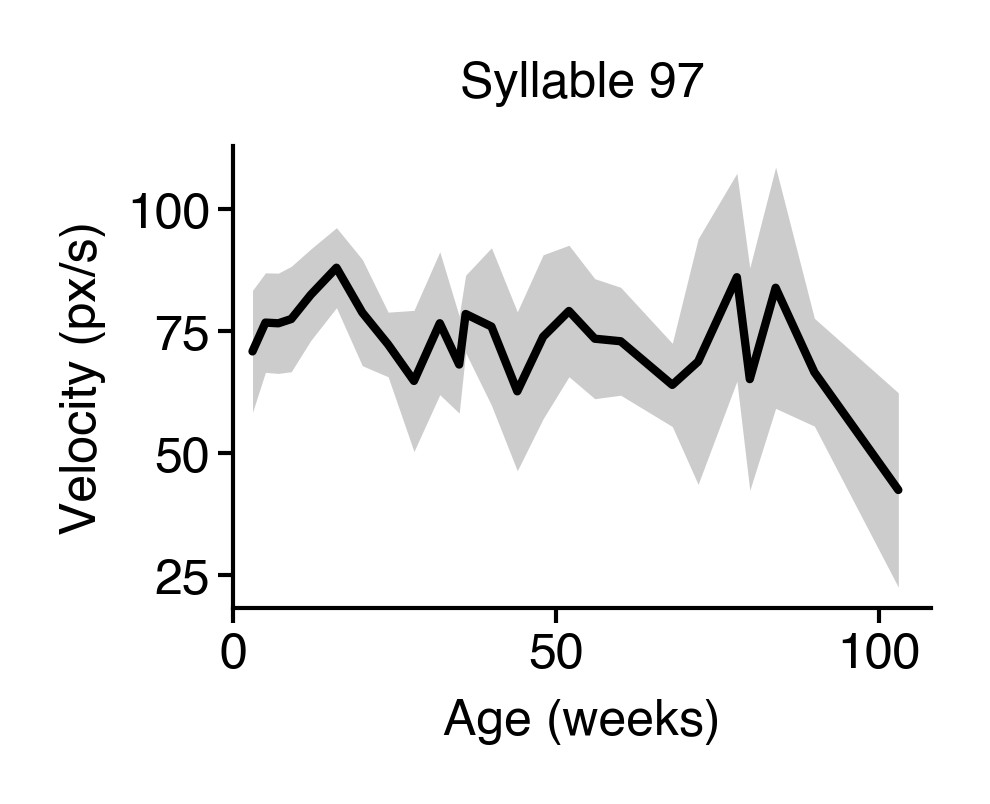

In [103]:
fig = figure(1.5, 1)
ax = sns.lineplot(
    data=session_avgs.filter(pl.col("syllables") == sorting[1]).with_columns(pl.col("corrected_velocity_2d") * 30),
    x="age",
    y="corrected_velocity_2d",
    errorbar="sd",
    err_kws={"lw": 0},
    c='k',
)
ax.set(ylabel="Velocity (px/s)", xlabel="Age (weeks)", title=f"Syllable {sorting[1]}", xlim=(0, None))
sns.despine()
saver(fig, "individual-syllable-speed-vs-age");

## Plot height for each syllable and age

In [98]:
syll_scalar_age_tbl = syllable_avgs.to_pandas().pivot_table(
    index="syllables", columns="age", values="height_ave_mm", aggfunc="mean"
)
syll_scalar_age_tbl.index.rename("Syllable ID", inplace=True)
syll_scalar_age_tbl.columns.rename("Age (weeks)", inplace=True)
drop_mask = syll_scalar_age_tbl.isna().sum(axis=1) > 3
sorting = syll_scalar_age_tbl[~drop_mask].mean(axis=1).sort_values(ascending=False).index

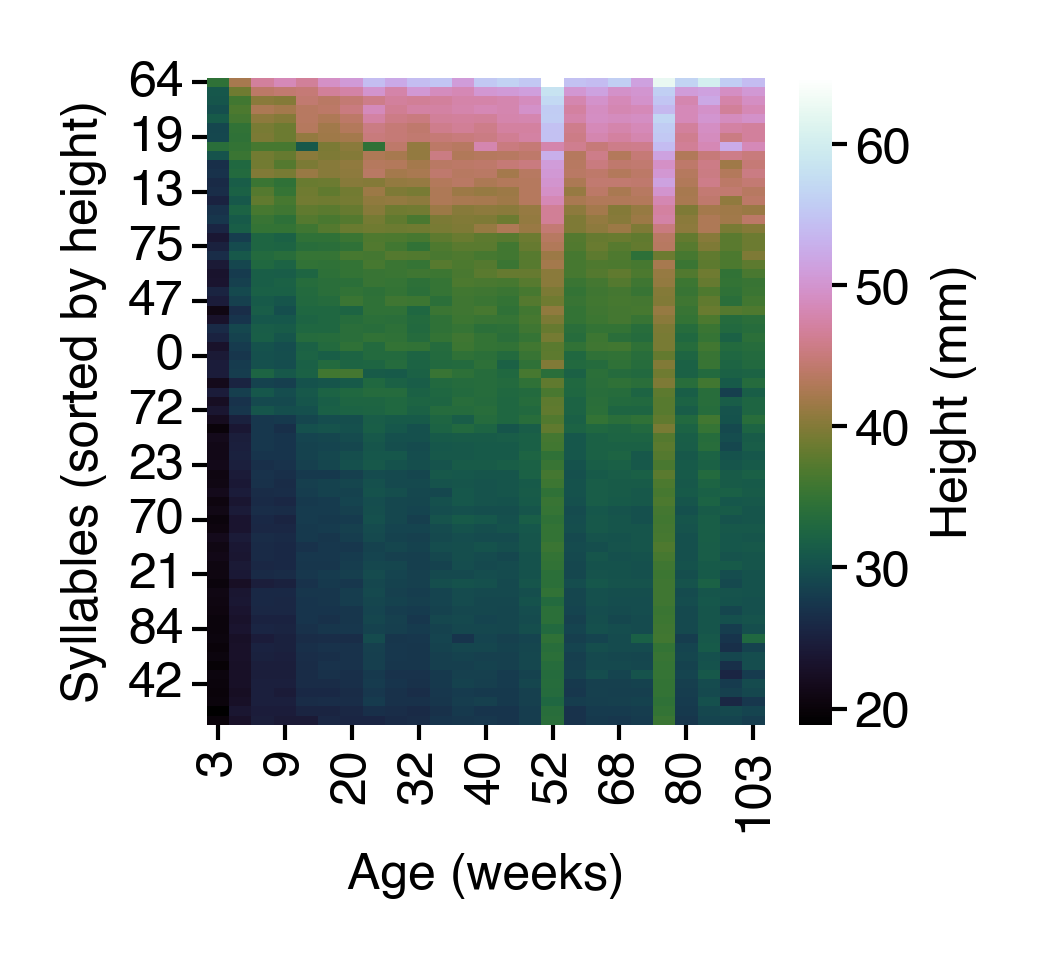

In [93]:
fig = figure(1.5, 1.4)
ax = sns.heatmap(
    syll_scalar_age_tbl.loc[sorting],
    cmap="cubehelix",
    cbar_kws={"label": "Height (mm)"},
)
ax.set(ylabel="Syllables (sorted by height)")
saver(fig, "syllables-vs-height-heatmap");

### Plot single syllable across sessions and age

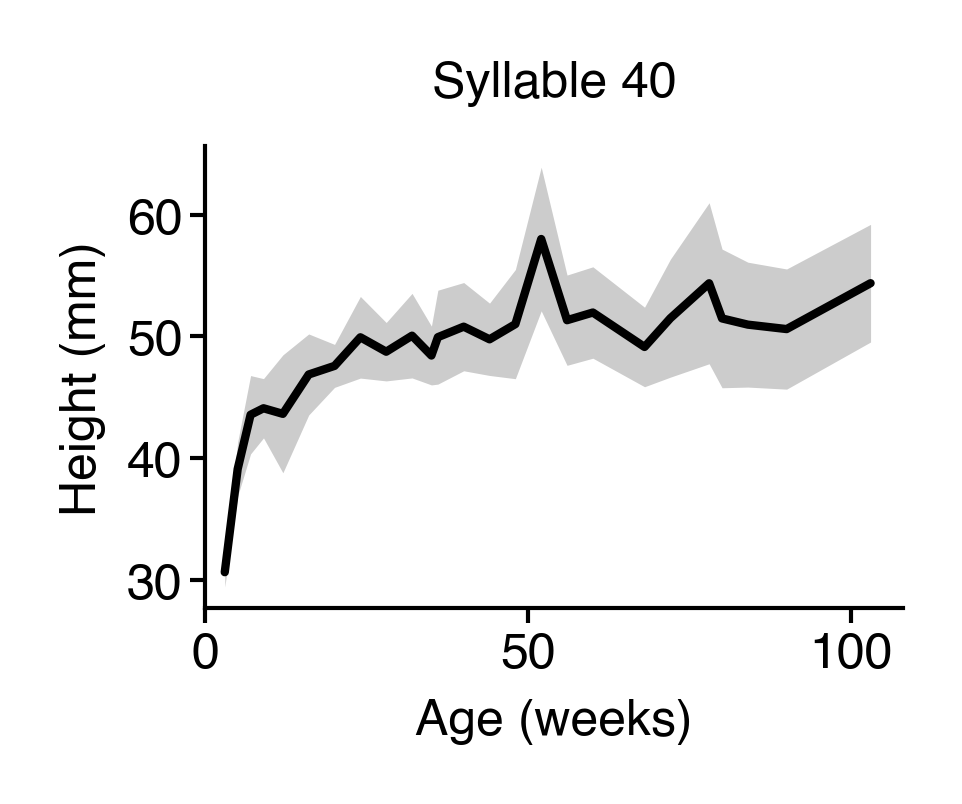

In [100]:
fig = figure(1.5, 1)
ax = sns.lineplot(
    data=session_avgs.filter(pl.col("syllables") == sorting[1]),
    x="age",
    y="height_ave_mm",
    errorbar="sd",
    err_kws={"lw": 0},
    c='k',
)
ax.set(ylabel="Height (mm)", xlabel="Age (weeks)", title=f"Syllable {sorting[1]}", xlim=(0, None))
sns.despine()
saver(fig, "individual-syllable-height-vs-age");